# Union of K intervals


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [628]:
class union_interval:
    "Assumes a uniform distribution of samples"
    def __init__(self, k = 3, epsilon = 0.1, gamma = 0.1, space = [-5,5], noise = 0, exact_n = True, const_w = False):
        self.intervals = np.sort(np.random.uniform(space[0] + 0.0001,space[1],2*k)).reshape(k,2)#intervals always smaller than sample space
        self.ep = epsilon
        self.gamma = gamma
        self.space = space #[space[0] + 0.0001, space[1] - 0.001]#ensure bu
        self.noise = noise
        self.exact_n = exact_n
        self.const_w = const_w
        self.k = k
        self.examples = np.array((space[0] - 1, 0, 0)).reshape(1,-1)#will always be ignored

    def add_example(self, ex):
        if ex.ndim == 1:#1d array
            self.examples = np.vstack((self.examples, ex))
        elif ex.ndim == 2:#2d array
            self.examples = np.concatenate((self.examples, ex), axis =0)#needs to be list
            
    def bin_search(intervals, i, k = 0):
        j = len(intervals)
        if j <= 1:
            return k
        if i < intervals[j//2]:
            return bin_search(intervals[:j//2], i, k)
        else:
            return bin_search(intervals[j//2:], i, k + j//2)
        
    def in_intervals(intervals, i):
        indx = bin_search(intervals[:,0], i)
        return intervals[indx, 0] <= i <= intervals[indx, 1]
        
    def sample(self, m = 1, samp = None, weight = None, label = None):
        if m == 1:
            samp = samp or np.random.uniform(self.space[0], self.space[1])#change sampling distribution here
            weight = float(weight or self.const_w or np.random.uniform(0,1))#wieghts random between 0 and 1
            label = label or in_intervals(self.intervals, samp)
            self.add_example(np.array((samp, weight, label)))
        else:
            samples = np.random.uniform(*self.space, m)#change sampling distribution here
            weights = np.random.uniform(int(self.const_w), 1, m)
            labels = np.array([in_intervals(self.intervals, i) for i in samples])
            self.add_example(np.column_stack((samples, weights, labels)))                   
    

    def estimate_intervals(self):
        #"Uses tight bounds as else might not be PAC learnable given divergent Distribution?"
        self.examples = self.examples[np.argsort(self.examples[:,0]), :]#might as well keep it sorted
        rand = np.random.choice(2, len(self.examples), p = [1-self.noise, self.noise])
        permutes = np.array([i if not j else j for i,j in zip(rand, self.examples[:,2])])
        permuted_ex = np.concatenate((self.examples[:,:-1], permutes.reshape(-1,1)), 1)
        
        made_intervals = [permuted_ex[:-1,2] != permuted_ex[1:,2]]#compare labels
        startstop = [0] + [i if i %2 == 1 else 0 for i in np.cumsum(made_intervals)]
        _, groups = np.unique(startstop, return_inverse = True)#need to exclude 0 group, need to leave in for spaceing
        num_vals = max(groups)
        indicies = [[] for i in range(num_vals+1)]#list of list of intervals locs [most specific]
        for counter, val in enumerate(groups):
            indicies[val].append(counter)#appends row index of interval at its group
        del indicies[0]
        weights = [0]*len(indicies)
        for cnter, lst in enumerate(indicies):
            weights[cnter] = np.sum(permuted_ex[lst, 1])
        final_indxs = [j for i,j in sorted(zip(weights, indicies), key = lambda x: x[0])][-self.k:]#is sorted in ascending order
        final_intervals = [0]*self.k
#         print(final_indxs, "\n\n", max([len(i) for i in indicies]))
        for cnt, lst in enumerate(final_indxs):
            if len(lst) == 1:
                final_intervals[cnt] = [permuted_ex[lst[0],0]]
            else: 
                final_intervals[cnt] = list((permuted_ex[lst[0],0], permuted_ex[lst[-1],0]))#+ permuted_ex[lst,0][-1]#get's first and last value in index
        return final_intervals, permutes
    
    def calc_error(self, est = None):
        error = 0
        if est is None:
            est, _ = self.estimate_intervals()
        srtest = sorted(est, key = lambda x: x[0])
        tru = self.intervals#already sorted
        print(srtest,"\n\n\n" tru)
        
        return np.sum([abs(i[0]-j[0])+abs(i[-1] - j[-1]) for i,j in zip(srtest, tru)])
        

In [629]:
test1 = union_interval(k = 5, noise = 0.3)
test1.sample(m = 100)
test1.examples = np.delete(test1.examples, 0, 0) 
est, permutes = test1.estimate_intervals()
tru = test1.intervals
# print(est, "\n\n", tru)
rand = np.random.choice(2, len(test1.examples), p = [1-0.2, 0.2])
test1.calc_error()

[[-3.4136497367221166, -3.0654832822490095], [-2.5520063861571574, -1.2386560930053694], [0.3968125694548865, 0.8171188926840687], [1.2441124370565468, 2.476668846971114], [3.186776638394095, 3.6365483991058642]] [[-2.85409814 -2.74627185]
 [-2.63908539 -1.21429945]
 [ 1.19323072  1.32092248]
 [ 1.38578462  2.53073216]
 [ 3.21526046  3.7441907 ]]


2.6222820341494466

In [424]:
test1.noise = 0.2
test1.estimate_intervals()

[[-4.97584842  0.30624009  0.        ]
 [-4.96228386  0.78313426  0.        ]
 [-4.95293035  0.13395461  0.        ]
 ...
 [ 4.94430096  0.54773028  0.        ]
 [ 4.94669405  0.57810315  0.        ]
 [ 4.94804463  0.519991    0.        ]]


[[0.23401600681000367, 0.3554720717586344],
 [-4.3016213418690254, -1.8561120695328794],
 [0.7978776001982588, 1.4867847251955641],
 [1.7226033496572066, 1.99198830450214],
 [-1.7297952673614336, 0.04945146100850639]]

In [384]:
print(test1.intervals, "\n\n\n", )
test1.examples[:,2].sum()

[[-4.25019392 -2.66335482]
 [-2.60564533 -2.3774418 ]
 [-1.60192371  1.31492414]
 [ 2.09121126  2.76124769]
 [ 2.96068774  3.35214897]]


563.0

[0.4862062094209091, 0.1277342608769274, 0.2973466100248844, 10.453868149595763, 0.7735163941276054, 0.7415232575574522, 0.2308225194287039, 4.546082146508479, 0.8059089842021874, 1.9059812275031318, 0.9375328782869627, 0.2370838464452636, 0.9756380417670488, 7.293592188651134, 0.805844787503454, 0.7767896504738471]
[2.9175164710060875]
[1.9757890227511563, 2.198397668578327]
[-0.04068094426130209, 0.5975746327408507]
[3.1962063081818304, 4.117412989553102]
[-4.020276879394878, -1.3232611948429018]
[-4.01872851 -1.28694836]
[-0.15623327  0.72201195]
[0.86631645 1.26164381]
[1.86495468 2.40004413]
[3.32379357 4.30403199]


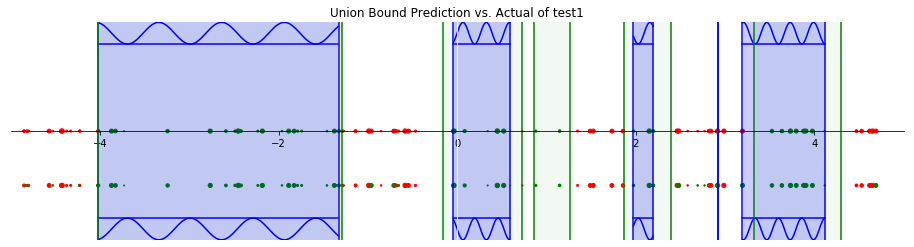

In [592]:
from matplotlib import colors
import matplotlib.transforms as mtransforms
import math

def plot_union(un_int, name = "test"):
    fig = plt.figure(figsize = (16, 4))
    ax = fig.add_subplot(1,1,1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['left'].set_color('white')
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_visible(False)
    plt.xlim(un_int.space)
    plt.ylim([-1,1])
    clrs = un_int.examples[:,2]
    wghts = un_int.examples[:,1]
    xvals = un_int.examples[:,0]
    cmap = colors.ListedColormap(['red', 'green'])
    plt.scatter(xvals,[0]*len(xvals), s = wghts*100/un_int.k, c = clrs, cmap = cmap)#be better as bars not pnts
    est_bnds, permutes = un_int.estimate_intervals()
    plt.scatter(xvals,[-0.5]*len(xvals), s = wghts*100/un_int.k, c = permutes, cmap = cmap)#be better as bars not pnts
    plt_bnds(est_bnds, ax, 'green', 0.2, est= True)
    tru_bnds = un_int.intervals
    plt_bnds(tru_bnds, ax, 'xkcd:lime', 0.05)
    plt.title(f"Union Bound Prediction vs. Actual of {name}. Error = ")

def plt_bnds(tru_bnds, ax, clr, alpha = 0.1, est= False):
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for bnd in tru_bnds:
        x = np.arange(bnd[0] - 0.000001, bnd[-1] + 0.000001, 0.01)
        clr = 'g'
        if est:
            clr = "b"
            plt.plot(x, [0.8]*len(x), c = clr)
            plt.plot(x, np.sin(x*min(24, 24/abs(bnd[0] - bnd[-1]+0.01)))*0.1+0.9, c = clr)
            plt.plot(x, [-0.8]*len(x), c = clr)
            plt.plot(x, np.sin(x*min(24, 24/abs(bnd[0] - bnd[-1]+0.01)))*-0.1 - 0.9, c = clr)
        plt.axvline(x=bnd[0], c = clr)
        plt.axvline(x=bnd[-1], c = clr)
        ax.fill_between(x, 0, 1, where= x >= bnd[0],
                facecolor=clr, alpha=alpha, transform=trans)#x limited to values between bnds, fills between all valid pnts
        
plot_union(test1, "test1")
